In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize, thin
from skimage.io import imshow
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [2]:
def RGBtoYCbCr (R, G, B):
    R = int(R)
    G = int(G)
    B = int(B)
    R /= 255.0
    G /= 255.0
    B /= 255.0
    Y = 16 + (65.481 * R + 128.553 * G + 24.966 * B)
    Cb = 128 + (-37.797 * R - 74.203 * G + 112.0 * B)
    Cr = 128 + (112.0 * R - 93.786 * G - 18.214 * B)
    return Y, Cb, Cr

In [3]:
def train(path):    
    content = ""
    with open(path, 'r') as file:
        content = file.read()
    entries = content.split('\n')
    dataset = dict()
    for line in entries:
        if line:
            R, G, B, label = line.split()
            label = int(label)
            if(label not in dataset):
                dataset[label] = []
            Y, Cb, Cr = RGBtoYCbCr(R, G, B)
            dataset[label].append([Cb, Cr])
    return dataset

In [4]:
def get_mean_cov(dataset):
    mean = dict()
    cov = dict()
    for label in dataset:
        data = np.array(dataset[label])
        mean[label] = np.mean(data, axis=0)
        cov[label] = np.cov(data, rowvar=False)
    return mean, cov

In [5]:
def prob_c_label(C, mean, cov):

    C = np.array(C)
    mean = np.array(mean)
    cov = np.array(cov)

    C_diff = C - mean
    inv_cov = np.linalg.inv(cov)
    prob = np.exp(-0.5 * np.sum(C_diff @ inv_cov * C_diff, axis=-1))

    norm_factor = np.sqrt(np.linalg.det(cov) * (2 * np.pi) ** C.shape[1])
    
    return prob / norm_factor

In [6]:
def prob_skin_c(C, skinMean, skinCov, nonSkinMean, nonSkinCov):
    probCskin = prob_c_label(C, skinMean, skinCov)
    probCnonSkin = prob_c_label(C, nonSkinMean, nonSkinCov)

    return probCskin / (probCskin + probCnonSkin)

In [27]:
def cleanMask(skin_mask):
    binary_mask = cv2.threshold(skin_mask, 0.25, 1, cv2.THRESH_BINARY)[1]
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, np.ones((3, 3)), iterations=3)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, np.ones((3, 3)), iterations=3)
    return binary_mask

In [24]:
def show_images(images,titles=None):
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [9]:
path = './Skin_NonSkin.txt'
dataset = train(path)

In [10]:
mean, cov = get_mean_cov(dataset)
skin_mean = mean[1]
skin_cov = cov[1]
non_skin_mean = mean[2]
non_skin_cov = cov[2]

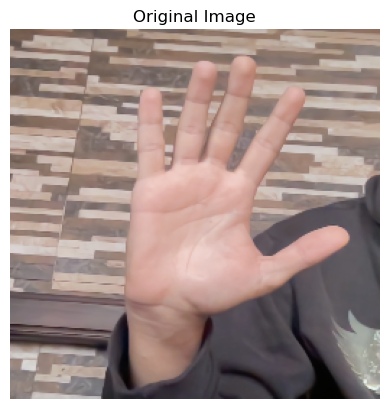

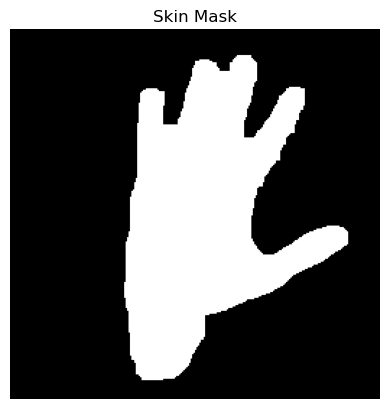

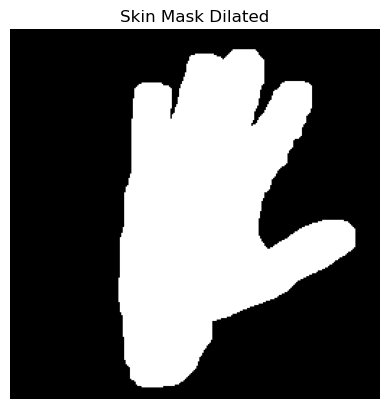

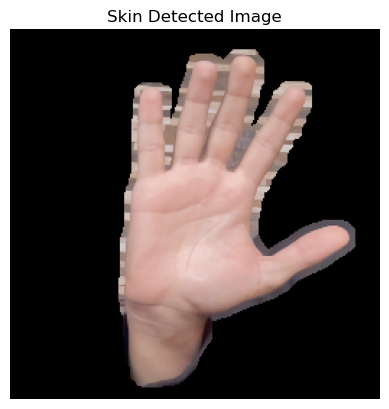

In [28]:
image = cv2.imread('/Users/zeyaddaowd/Desktop/sora0.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256))
original = image.copy()
YCC = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
image = image.astype(np.float64) / 255
C = YCC[:, :, 1:]
skin_mask = np.zeros((image.shape[0], image.shape[1]))
skin_mask = prob_skin_c(C, skin_mean, skin_cov, non_skin_mean, non_skin_cov)
skin_mask = cleanMask(skin_mask)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
skin_mask_dilated = cv2.dilate(skin_mask, kernel)


show_images([original], ['Original Image'])
show_images([skin_mask], ['Skin Mask'])
show_images([skin_mask_dilated], ['Skin Mask Dilated'])

show_images([image * skin_mask_dilated[:, :, np.newaxis]], ['Skin Detected Image'])


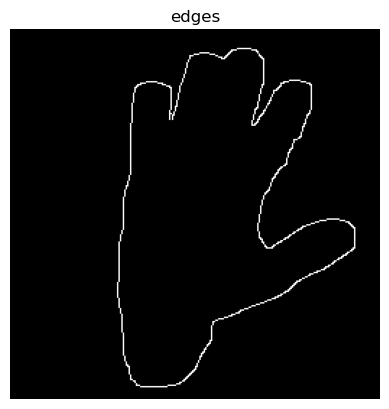

In [72]:
hand_detected = skin_mask_dilated
edges_hand = cv2.Canny(cv2.GaussianBlur((hand_detected * 255).astype(np.uint8), (5,5), 0), threshold1=50, threshold2=150)
show_images([edges_hand], ['edges'])

## Thinning Trial

In [105]:
def do_skeltonization(to_skeletonize):
    return cv2.ximgproc.thinning(cv2.GaussianBlur((to_skeletonize * 255).astype(np.uint8), (5,5), 0)) / 255

In [106]:
def get_end_points(skeletonized):
    coordinates = []
    for i in range(1, skeletonized.shape[0] - 1):
        for j in range(1, skeletonized.shape[1] - 1):
            pix = skeletonized[i, j]
            if pix == 0:
                continue
            count = 0
            for y in range(-1, 2):
                for x in range(-1, 2):
                    pix = skeletonized[i + y, j + x]
                    if pix != 0:
                        count += 1
            if count == 2:
                coordinates.append((i, j))
    return coordinates

In [107]:
def draw_circles(img, coordinates):
    res_5 = np.copy(img)
    for (x, y) in coordinates:
        cv2.circle(res_5, (y, x), radius=5, color=(0, 0, 1), thickness=-1)
    return res_5

In [108]:
skeletonized = do_skeltonization(np.copy(skin_mask_dilated))
coordinates = get_end_points(skeletonized)
result = draw_circles(image, coordinates=coordinates)

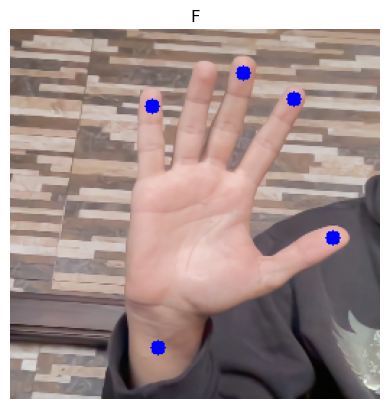

In [109]:
show_images([result], "Fingers Detected Using Skeletonization")

## Convexity Hull trial

In [110]:
ret, threshold = cv2.threshold(edges_hand, 10/255, 1, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [111]:
contour = max(contours, key=cv2.contourArea)

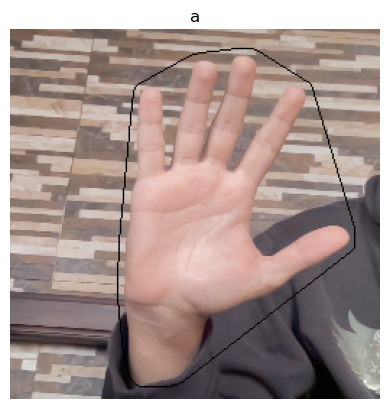

In [112]:
hull_points = cv2.convexHull(contour)
res = np.copy(image)
cv2.drawContours(res, [hull_points], -1, (0, 0, 0))  # Blue line for the hull
show_images([res],"a")

In [113]:
epsilon = 0.01 * cv2.arcLength(contour, True)
approx = cv2.approxPolyDP(contour, epsilon, True)

In [102]:
hull_idx = cv2.convexHull(approx, returnPoints=False)
for each in [hull_idx]:
    defects = cv2.convexityDefects(approx, hull_idx)


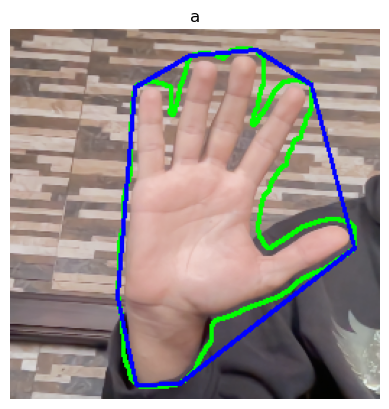

In [103]:
res_3 = image.copy()
hull = cv2.convexHull(approx, returnPoints=True)
# Draw original contour in green
cv2.drawContours(res_3, [contour], 0, (0,1,0), 2)

# Draw hull in red
cv2.drawContours(res_3, [hull], 0, (0,0,1), 2)
show_images([res_3], "a")

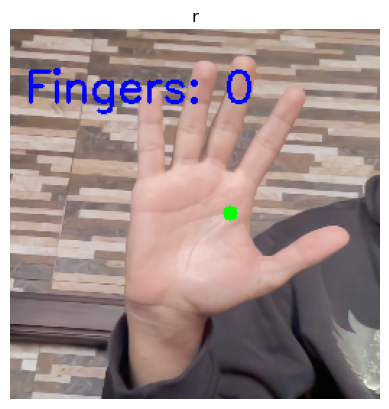

In [114]:
epsilon = 0.1 * cv2.arcLength(contour, True)
approx = cv2.approxPolyDP(contour, epsilon, True)

hull_idx = cv2.convexHull(approx, returnPoints=False)
defects = cv2.convexityDefects(approx, hull_idx)

rect = cv2.minAreaRect(contour)
box = cv2.boxPoints(rect)
box = np.int32(box)  
center_x, center_y = np.int32(rect[0])  

res_2 = image.copy()
cv2.circle(res_2, (center_x, center_y), 5, (0, 1, 0), -1)

number_of_fingers = 0
height = rect[1][1]  

if defects is not None:
    for i in range(defects.shape[0]):
        start_idx, end_idx, farthest_idx, depth = defects[i, 0]
        start_point = tuple(contour[start_idx][0])
        end_point = tuple(contour[end_idx][0])
        depth_point = tuple(contour[farthest_idx][0])

        cv2.circle(res_2, start_point, 5, (1, 0, 0), -1)
        cv2.circle(res_2, depth_point, 5, (0, 1, 1), -1)
        cv2.circle(res_2, end_point, 5, (0, 0, 1), -1)

        if (
            (start_point[1] < center_y or depth_point[1] < center_y)  
            and start_point[1] < depth_point[1]  
            and np.linalg.norm(np.array(start_point) - np.array(depth_point)) > height / 6.5
        ):
            number_of_fingers += 1

cv2.putText(res_2, f"Fingers: {number_of_fingers}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 1), 2)

show_images([res_2], "result")
